In [84]:
# import lib
import numpy      as np
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from   plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# data set 
import sklearn.datasets as datasets

init_notebook_mode(connected=True); np.random.seed(6789); tf.set_random_seed(67890); plt.style.use('seaborn')

In [183]:
# create functions and start session
try: 
    if sess._closed: sess = tf.InteractiveSession()
except:
    sess = tf.InteractiveSession()
def np_pca_svd(X):
    U,s,VT = np.linalg.svd(X,full_matrices=False)
    S      = np.diag(s)
    return U,S,VT.T
    
def tf_pca_svd(X,mmax=1.5,mmin=0.5): 
    s,U,V  = tf.linalg.svd(X,full_matrices=False)
    S      = tf.diag(s)
    s      = s.eval()
    ScaledS= (mmax-mmin)*((s-s.min())/(s.max()-s.min())) + mmin
    return U.eval(),S,V.eval(),ScaledS

def normalize_sign(A,B):
    """
    utility function for resolving the sign ambiguity in SVD
    http://stats.stackexchange.com/q/34396/115202
    """
    signs = np.sign(A) * np.sign(B)
    return A, B * signs    

def plot_data_with_pca(data,vector,value,cenx=0,ceny=0,width=0.05,title=None,save_fig=False,show_fig=True,close=True,alpha=1.0):
    plt.scatter(data[:,0],data[:,1],c=label,cmap='YlOrBr',alpha=alpha)
    ax1 = plt.arrow(cenx,ceny,*vector[:,0]*value[0],width=width,length_includes_head=False,color='Red' ,capstyle='projecting',label='PC 1',alpha=alpha)
    ax2 = plt.arrow(cenx,ceny,*vector[:,1]*value[1],width=width,length_includes_head=False,color='Blue',capstyle='projecting',label='PC 2',alpha=alpha)
    if title: plt.title(title,fontsize=30)
    plt.legend([ax1,ax2],['pc 1','pc 2']); plt.tight_layout()
    if save_fig: plt.savefig('figure/'+str(title)+'.png')
    if show_fig: plt.show()
    if close   : plt.close('all')
    
def normalize_with_range(data,mmax=1.,mmin=0.0):
    norm_data = (mmax-mmin) * ((data - data.min(0,keepdims=True))/ (data.max(0,keepdims=True)-data.min(0,keepdims=True))) + mmin
    return norm_data

number_of_data = 4000
skew_matrix    = np.array([[2,0.2],[1.1,0]])

=============================== FIND PC ============================
Are the two projection vector same? :  True
=============================== FIND PC ============================
=============================== PROJECTION ============================
Are the two PROJECTED DATA same?   :  True
Are the two PROJECTED VECTOR same? :    True
=============================== PROJECTION ============================
================================= RECONSTRUCTION ==========================
Are the two RECONSTRUCTED DATA same?   :  True
Are the two RECONSTRUCTED VECTOR same? :  True
================================= RECONSTRUCTION ==========================
Are the ORIGINAL and RECONSTRUCTED DATA same?   :  True
Are the ORIGINAL and RECONSTRUCTED DATA same?   :  True
Are the ORIGINAL and RECONSTRUCTED VECTOR same? :  True
Are the ORIGINAL and RECONSTRUCTED VECTOR same? :  True


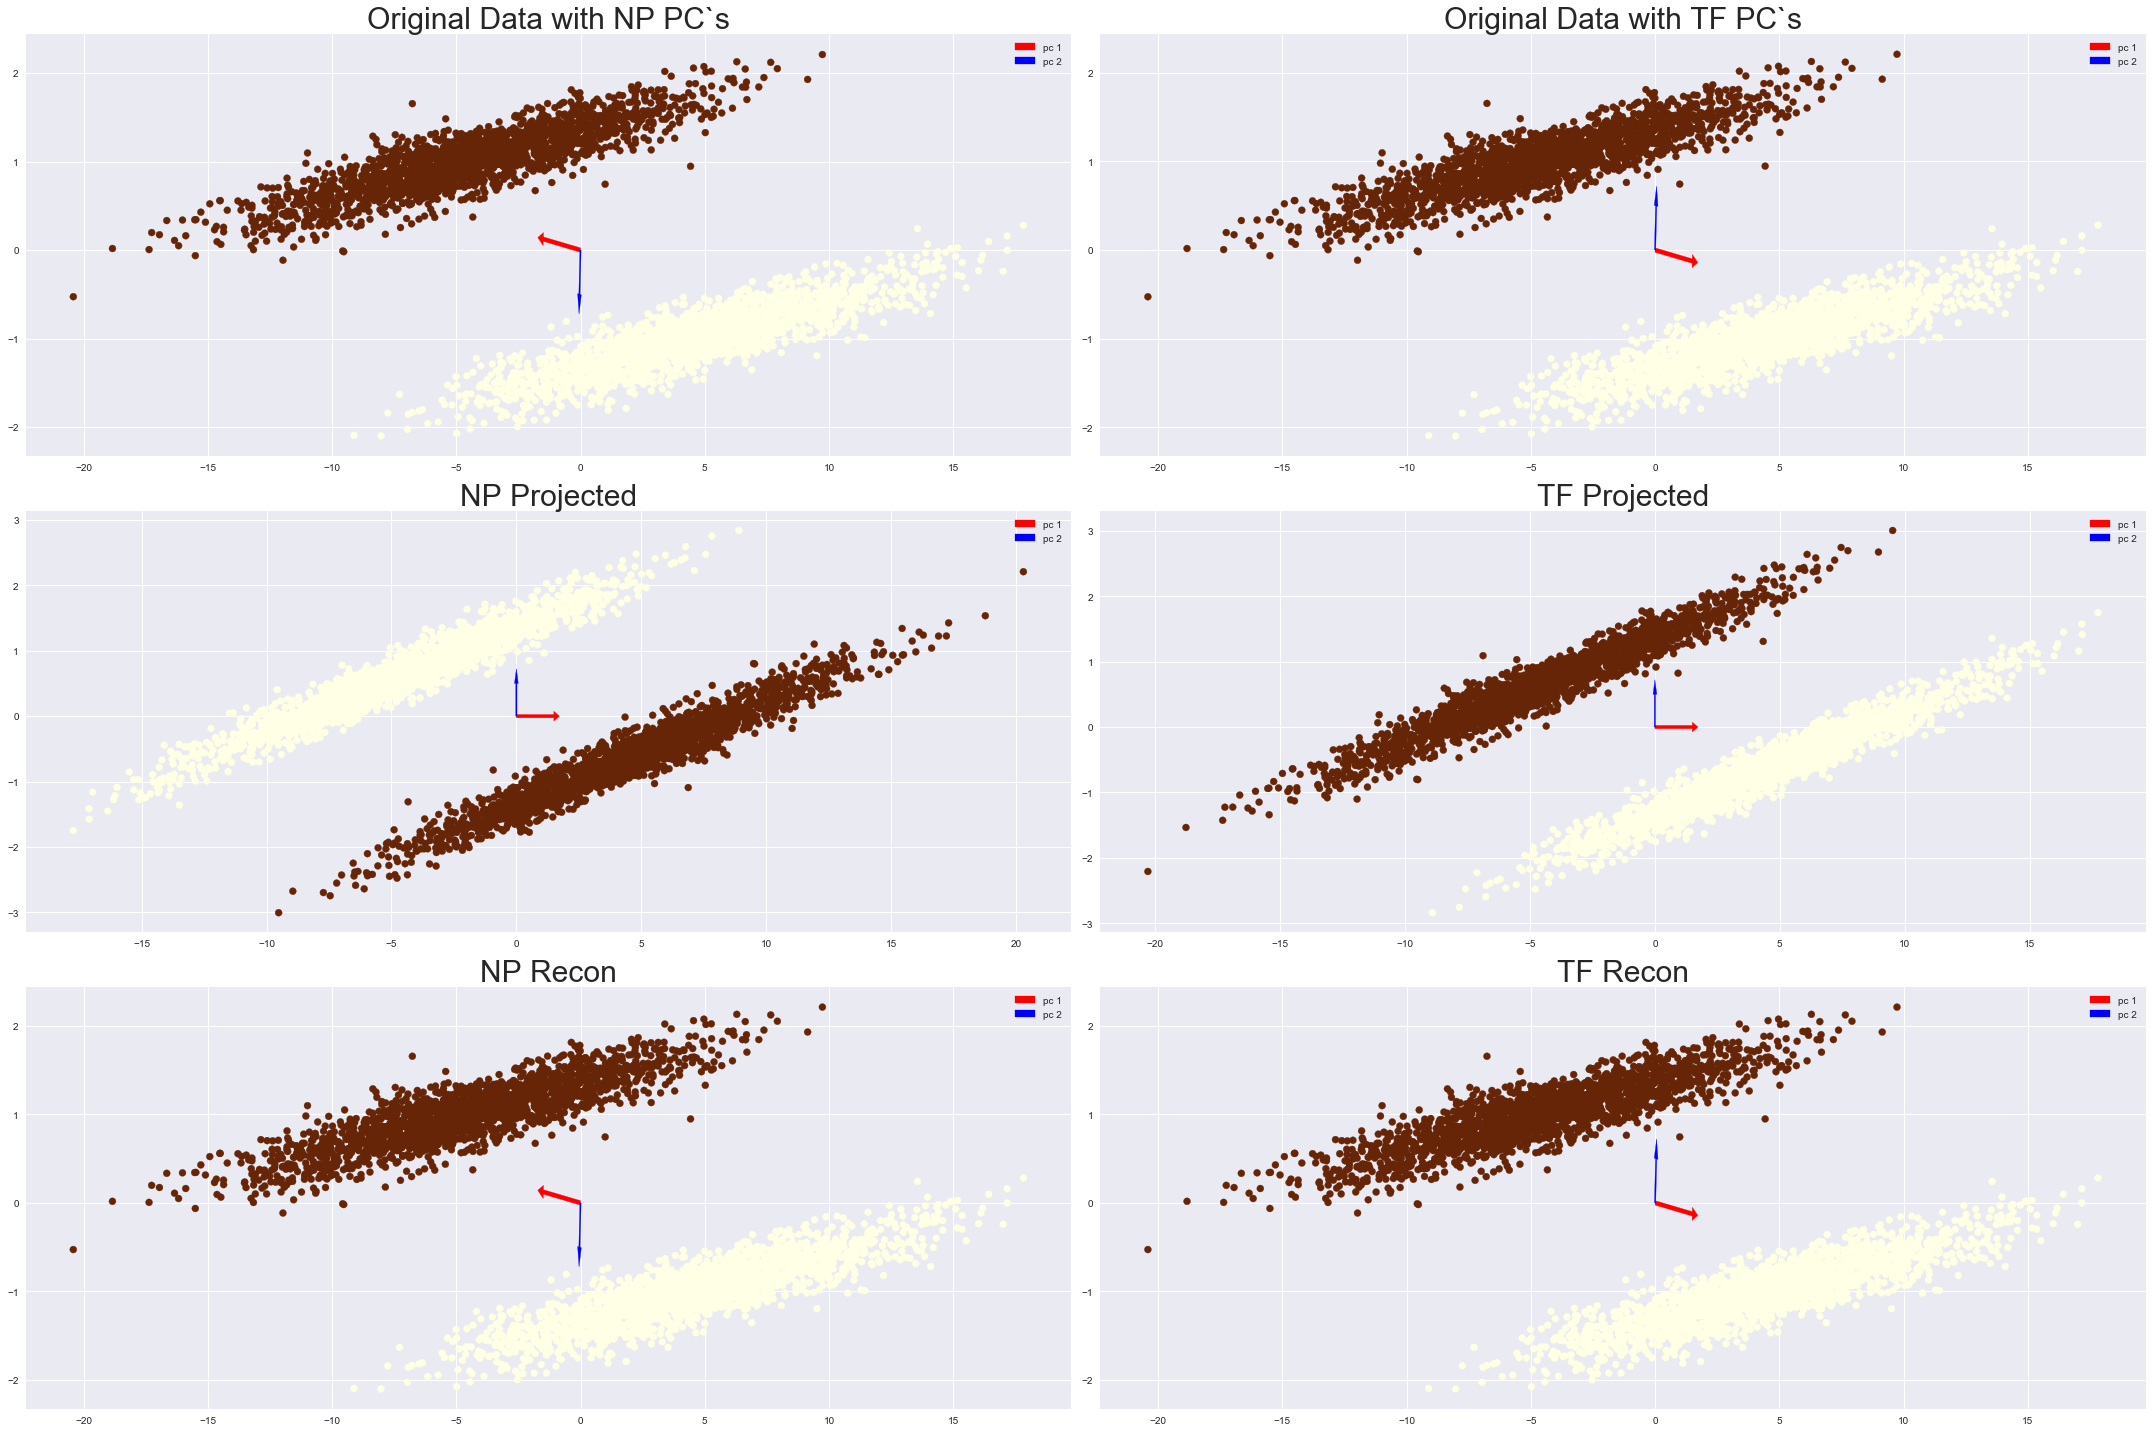

In [184]:
# create some simple dataset blobs and skew it (center it as well)
data,label = datasets.make_blobs(n_samples=number_of_data,centers=2,random_state=23,cluster_std =1.9,center_box =(-20,20))
data       = data @ skew_matrix
data       = data - data.mean(0,keepdims=True)

# ==================================== FIND PC =====================================================
cov     = data.T @ data / (data.shape[0] - 1)
val,vec = np.linalg.eigh(cov)
vec     = vec.T
vec     = vec[:,::-1]; val     = val[::-1]

og_U,og_S,og_V,og_ss = tf_pca_svd(data)

print('=============================== FIND PC ============================')
print('Are the two projection vector same? : ',np.allclose(*normalize_sign(vec,og_V)))
print('=============================== FIND PC ============================')
# ==================================== FIND PC =====================================================

# =================================== PROJECTION ======================================================
np_projected_data = data   @ vec
np_projected_veco = vec.T  @ vec

tf_projected_data = (og_U  @ og_S).eval()
tf_projected_veco = og_V.T @ og_V
print('=============================== PROJECTION ============================')
print('Are the two PROJECTED DATA same?   : '  ,np.allclose(*normalize_sign(np_projected_data,tf_projected_data)))
print('Are the two PROJECTED VECTOR same? :   ',np.allclose(*normalize_sign(np_projected_veco,tf_projected_veco)))
print('=============================== PROJECTION ============================')
# =================================== PROJECTION ======================================================

# =================================== RECONSTRUCTION ======================================================
np_reconstructed_data = np_projected_data @ vec.T
np_reconstructed_veco = np_projected_veco @ vec

tf_reconstructed_data = tf_projected_data @ og_V.T
tf_reconstructed_veco = tf_projected_veco @ og_V
print('================================= RECONSTRUCTION ==========================')
print('Are the two RECONSTRUCTED DATA same?   : ',np.allclose(*normalize_sign(np_reconstructed_data,tf_reconstructed_data)))
print('Are the two RECONSTRUCTED VECTOR same? : ',np.allclose(*normalize_sign(np_reconstructed_veco,tf_reconstructed_veco)))
print('================================= RECONSTRUCTION ==========================')

print('===========================================================')
print('Are the ORIGINAL and RECONSTRUCTED DATA same?   : ',np.allclose(*normalize_sign(np_reconstructed_data,data)))
print('Are the ORIGINAL and RECONSTRUCTED DATA same?   : ',np.allclose(*normalize_sign(tf_reconstructed_data,data)))
print('Are the ORIGINAL and RECONSTRUCTED VECTOR same? : ',np.allclose(*normalize_sign(np_reconstructed_veco,vec)))
print('Are the ORIGINAL and RECONSTRUCTED VECTOR same? : ',np.allclose(*normalize_sign(tf_reconstructed_veco,og_V)))
print('===========================================================')
# =================================== RECONSTRUCTION ======================================================

plt.figure(figsize=(30,20))
plt.subplot(321); plot_data_with_pca(data,vec ,og_ss,title='Original Data with NP PC`s',show_fig=False,close=False)
plt.subplot(322); plot_data_with_pca(data,og_V,og_ss,title='Original Data with TF PC`s',show_fig=False,close=False)
plt.subplot(323); plot_data_with_pca(np_projected_data,np_projected_veco,og_ss,title='NP Projected',show_fig=False,close=False)
plt.subplot(324); plot_data_with_pca(tf_projected_data,tf_projected_veco,og_ss,title='TF Projected',show_fig=False,close=False)
plt.subplot(325); plot_data_with_pca(np_reconstructed_data,np_reconstructed_veco,og_ss,title='NP Recon',show_fig=False,close=False)
plt.subplot(326); plot_data_with_pca(tf_reconstructed_data,tf_reconstructed_veco,og_ss,title='TF Recon',show_fig=False,close=False)
plt.show()

=============================== PROJECTION ============================
Are the two PROJECTED DATA same?   :  True
Are the two PROJECTED VECTOR same? :    True
=============================== PROJECTION ============================


ValueError: c of shape (4000,) not acceptable as a color sequence for x with size 2, y with size 2

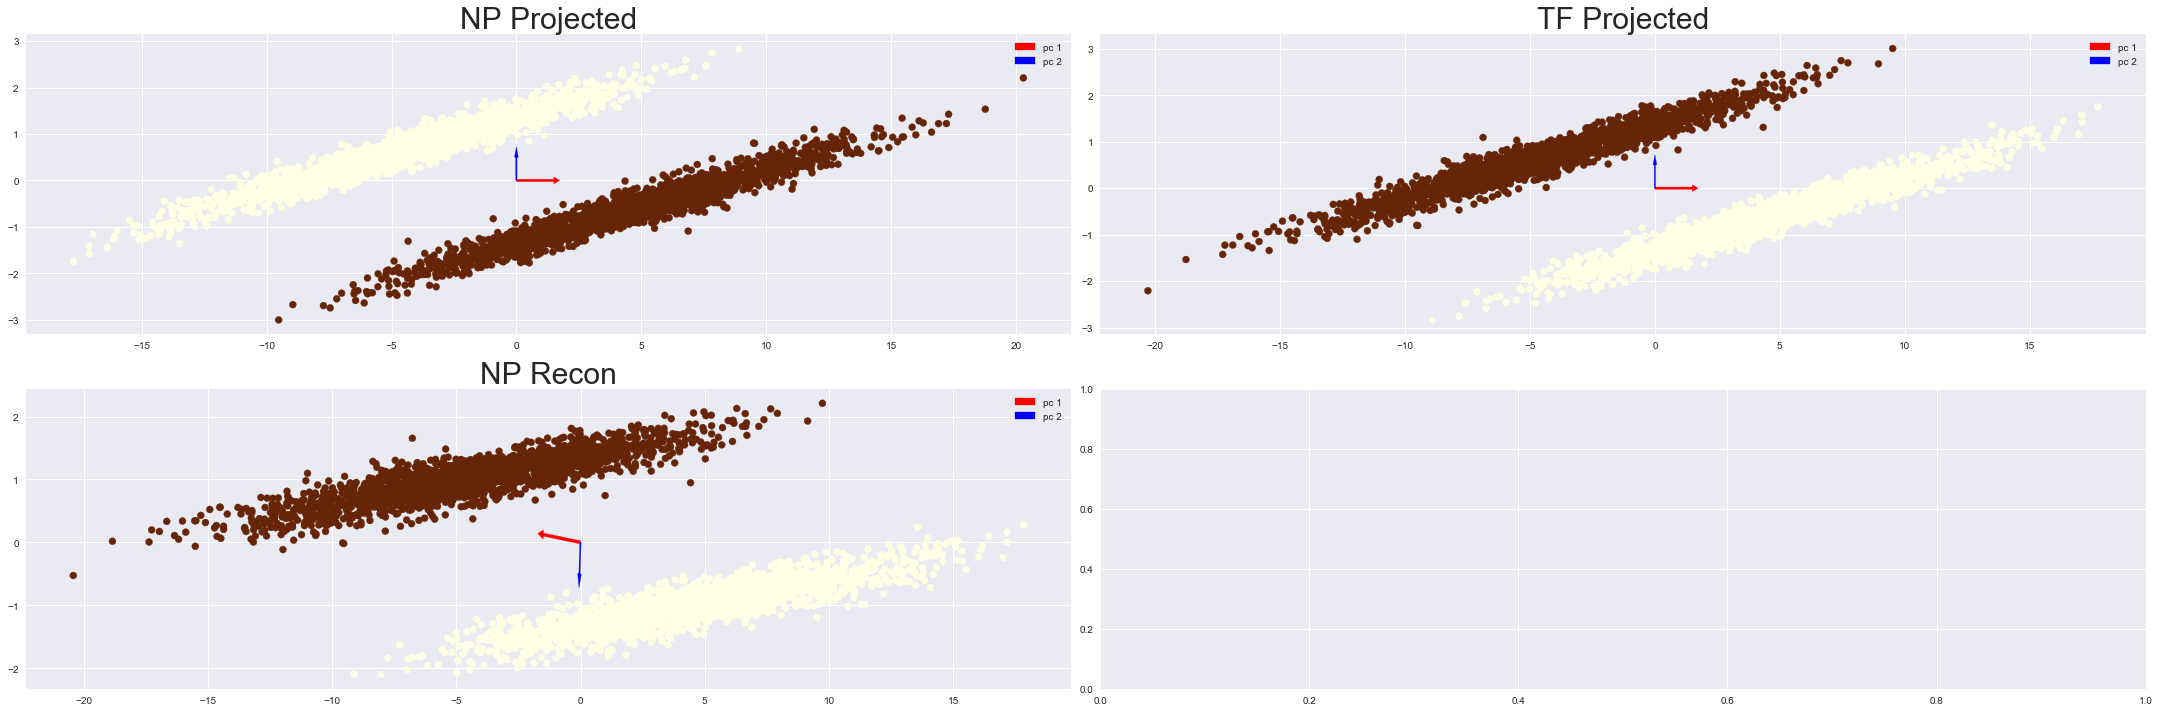

In [186]:
# now in the reconstructed section play 
# =================================== PROJECTION ======================================================
np_projected_data = data   @ vec
np_projected_veco = vec.T  @ vec

tf_projected_data = (og_U  @ og_S).eval()
tf_projected_veco = og_V.T @ og_V
print('=============================== PROJECTION ============================')
print('Are the two PROJECTED DATA same?   : '  ,np.allclose(*normalize_sign(np_projected_data,tf_projected_data)))
print('Are the two PROJECTED VECTOR same? :   ',np.allclose(*normalize_sign(np_projected_veco,tf_projected_veco)))
print('=============================== PROJECTION ============================')
# =================================== PROJECTION ======================================================

# ======== modify the reconstruction vector
np_vec_m =  vec # * (vec * og_ss[:,None]).std(0,keepdims=True)
og_S_temp= og_S.eval()
tf_vec_m =  og_V  * (og_V.T * og_S_temp[None,:]).std(0,keepdims=True)
# ======== modify the reconstruction vector

# =================================== RECONSTRUCTION ======================================================
np_reconstructed_data = np_projected_data @ np_vec_m.T
np_reconstructed_veco = np_projected_veco @ vec

tf_reconstructed_data = tf_projected_data @ tf_vec_m.T
tf_reconstructed_veco = tf_projected_veco @ og_V
# print('================================= RECONSTRUCTION ==========================')
# print('Are the two RECONSTRUCTED DATA same?   : ',np.allclose(*normalize_sign(np_reconstructed_data,tf_reconstructed_data)))
# print('Are the two RECONSTRUCTED VECTOR same? : ',np.allclose(*normalize_sign(np_reconstructed_veco,tf_reconstructed_veco)))
# print('================================= RECONSTRUCTION ==========================')

# print('===========================================================')
# print('Are the ORIGINAL and RECONSTRUCTED DATA same?   : ',np.allclose(*normalize_sign(np_reconstructed_data,data)))
# print('Are the ORIGINAL and RECONSTRUCTED DATA same?   : ',np.allclose(*normalize_sign(tf_reconstructed_data,data)))
# print('Are the ORIGINAL and RECONSTRUCTED VECTOR same? : ',np.allclose(*normalize_sign(np_reconstructed_veco,vec)))
# print('Are the ORIGINAL and RECONSTRUCTED VECTOR same? : ',np.allclose(*normalize_sign(tf_reconstructed_veco,og_V)))
# print('===========================================================')
# =================================== RECONSTRUCTION ======================================================

plt.figure(figsize=(30,10))
plt.subplot(221); plot_data_with_pca(np_projected_data,np_projected_veco,og_ss,title='NP Projected',show_fig=False,close=False)
plt.subplot(222); plot_data_with_pca(tf_projected_data,tf_projected_veco,og_ss,title='TF Projected',show_fig=False,close=False)
plt.subplot(223); plot_data_with_pca(np_reconstructed_data,np_reconstructed_veco,og_ss,title='NP Recon',show_fig=False,close=False)
plt.subplot(224); plot_data_with_pca(tf_reconstructed_data,tf_reconstructed_veco,og_ss,title='TF Recon',show_fig=False,close=False)
plt.show()

In [155]:
print(vec)
print(val)
print(vec * val[None,:])
print((vec * val[None,:]).mean(0,keepdims=True) )
print( vec * (vec * val[None,:]).std(0,keepdims=True) )

[[-0.99659628 -0.08243696]
 [ 0.08243696 -0.99659628]]
[39.31837178  0.88742539]
[[-39.1845431   -0.07315665]
 [  3.24128707  -0.88440484]]
[[-17.97162802  -0.47878075]]
[[-21.14071228  -0.03343842]
 [  1.74872825  -0.40424346]]


In [130]:
og_S.eval()

array([[396.52763935,   0.        ],
       [  0.        ,  59.57192402]])

In [136]:
0.08243696  * 39.31837178

3.241287041692989

In [179]:
og_S.eval().shape

(2, 2)

### Tensorflow SVD already tranposes the V matrix
<img src="https://i.imgur.com/im9zhFr.png"> 

### As seen above there is a method called adjoint_b and this indicates the fact that we are tranposing v 
### To recover the original value of data we need to transpose the V

In [17]:
a = data
s, u, v = tf.linalg.svd(a)
tf_a_approxT = tf.matmul(u, tf.matmul(tf.linalg.diag(s), v)) 
tf_a_approx  = tf.matmul(u, tf.matmul(tf.linalg.diag(s), tf.transpose(v)) )
u, s, v_adj  = np.linalg.svd(a, full_matrices=False)
np_a_approx  = np.dot(u, np.dot(np.diag(s), v_adj))
tf_a_approxT = tf_a_approxT.eval()
tf_a_approx  = tf_a_approx.eval()
print('Did not Transpose: ',np.allclose(np_a_approx,tf_a_approxT))
print('Did Transpose: ',np.allclose(np_a_approx,tf_a_approx))

Did not Transpose:  False
Did Transpose:  True


# Reference 
1. PCA?, R. (2018). Relationship between SVD and PCA. How to use SVD to perform PCA?. Cross Validated. Retrieved 15 November 2018, from https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca
2. tf.linalg.svd | TensorFlow. (2018). TensorFlow. Retrieved 15 November 2018, from https://www.tensorflow.org/api_docs/python/tf/linalg/svd
3. Line and Scatter Plots. (2018). Plot.ly. Retrieved 15 November 2018, from https://plot.ly/matplotlib/line-and-scatter/
4. exception)?, H. (2018). How to check if a Tensorflow Session is still open (without catching an exception)?. Stack Overflow. Retrieved 15 November 2018, from https://stackoverflow.com/questions/42974627/how-to-check-if-a-tensorflow-session-is-still-open-without-catching-an-exceptio
5. sklearn.datasets.make_blobs — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 15 November 2018, from https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
6. Styling Markers. (2018). Plot.ly. Retrieved 15 November 2018, from https://plot.ly/python/marker-style/
7. Subplots. (2018). Plot.ly. Retrieved 15 November 2018, from https://plot.ly/python/subplots/
8. matplotlib, S. (2018). Seaborn configuration hides default matplotlib. Stack Overflow. Retrieved 15 November 2018, from https://stackoverflow.com/questions/33099348/seaborn-configuration-hides-default-matplotlib
9. color example code: colormaps_reference.py — Matplotlib 2.0.2 documentation. (2018). Matplotlib.org. Retrieved 15 November 2018, from https://matplotlib.org/examples/color/colormaps_reference.html
10. matplotlib.pyplot.arrow — Matplotlib 3.0.2 documentation. (2018). Matplotlib.org. Retrieved 15 November 2018, from https://matplotlib.org/api/_as_gen/matplotlib.pyplot.arrow.html
11. notebook?, H. (2018). How to set the matplotlib figure default size in ipython notebook?. Stack Overflow. Retrieved 15 November 2018, from https://stackoverflow.com/questions/17230797/how-to-set-the-matplotlib-figure-default-size-in-ipython-notebook
12. arrow, M. (2018). Matplotlib legend for an arrow. Stack Overflow. Retrieved 15 November 2018, from https://stackoverflow.com/questions/22348229/matplotlib-legend-for-an-arrow
13. value?, H. (2018). How to use a decimal range() step value?. Stack Overflow. Retrieved 15 November 2018, from https://stackoverflow.com/questions/477486/how-to-use-a-decimal-range-step-value